In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Objectif du notebook

A partir des prédictions réalisées sur la Consommation et les productions éolienne, solaire et hydraulique, l'objectif est de "calculer" la balance en considérant :
* la production bioénergie est négligeable
* la production thermique est nulle (arrêt de ces installations)
* la production nucléaire est une constante qui correspond à un pourcentage de la capacité disponible (taux de charge).

NB : le taux de charge permet de prendre en compte les phases de maintenance des installations concernées.

## Meilleures prédictions effectuées pour chaque filière d'énergie

On récupère les meilleurs résultats de prédiction obtenus suivant les différents modèles testés pour chaque filière.

In [2]:
solaire = pd.read_csv('./results/3h/bilan_solaire_3h.csv', sep = ';',
                     usecols = ['Dates', 'Sol_p_exog'])
hydraulique = pd.read_csv('./results/3h/bilan_hydraulique_3h.csv', sep = ';',
                     usecols = ['Hyd_p_exog'])
eolien = pd.read_csv('./results/3h/bilan_eolien_3h.csv', sep = ';',
                     usecols = ['Eol_p_LinReg'])
consommation = pd.read_csv('./results/3h/bilan_consommation_3h.csv', sep = ';',
                     usecols = ['Conso_p_exog'])

In [3]:
df = pd.concat([solaire, hydraulique, eolien, consommation], axis = 1)

In [4]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

## Définition du cycle d'utilisation de l'énergie nucléaire

On considère que l'énergie nucléaire est pilotée par l'homme suivant les contraintes suivantes :
* planifier les opérations de maintenance sur l'ensemble du parc
* répondre au besoin lié à la consommation

La consommation étant cyclique, avec une période intense pendant l'hiver, on considère que le planning annuel de production de l'énergie nucléaire est une constante. On la définira en calculant la moyenne sur la période.

In [5]:
nucleaire = pd.read_csv('./dataset/France_3H.csv',
                     usecols = ['Dates', 'Nucléaire'])
nucleaire['Dates'] = pd.to_datetime(nucleaire['Dates'], yearfirst = True)

In [6]:
nucleaire['Mois'] = nucleaire['Dates'].dt.month
nucleaire['Jour'] = nucleaire['Dates'].dt.day
nucleaire['Heure'] = nucleaire['Dates'].dt.hour

In [7]:
avg_nucleaire = nucleaire[['Nucléaire', 'Mois', 'Jour', 'Heure']]
avg_nucleaire = avg_nucleaire.groupby(['Mois', 'Jour', 'Heure']).mean()
avg_nucleaire.reset_index(inplace = True)
avg_nucleaire.rename({'Nucléaire' : 'Avg_nucleaire'}, axis = 1, inplace = True)

In [8]:
nucleaire = pd.merge(nucleaire, avg_nucleaire, how = 'left', left_on = ['Mois', 'Jour', 'Heure'], right_on = ['Mois', 'Jour', 'Heure'])
nucleaire.drop(['Mois', 'Jour', 'Heure'], axis = 1, inplace = True)
nucleaire.set_index('Dates', inplace = True)

In [9]:
nucleaire[['Nucléaire', 'Avg_nucleaire']].to_csv('nucleaire.csv', sep=';')

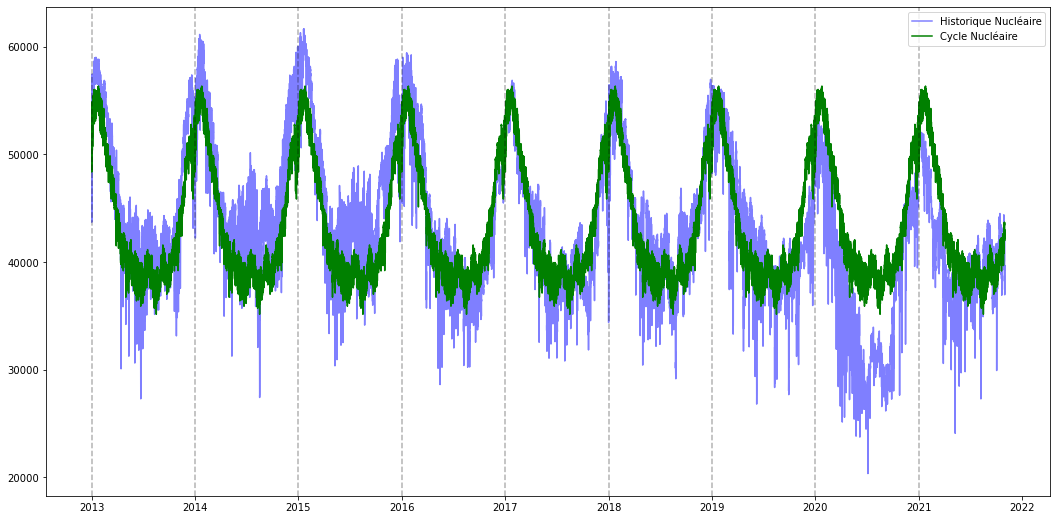

In [10]:
plt.figure(figsize = (18, 9))
plt.plot(nucleaire['Nucléaire'], color = 'b', alpha = 0.5, label = 'Historique Nucléaire')
plt.plot(nucleaire['Avg_nucleaire'], color = 'g', label = 'Cycle Nucléaire')
plt.legend(loc = 'upper right')
for i in range(2013, 2022):
    plt.axvline(dt.datetime(i, 1, 1), color = 'k', alpha = 0.3, linestyle = '--');

In [11]:
nucleaire = nucleaire[(nucleaire.index >= dt.datetime(2020,1,1))&(nucleaire.index < dt.datetime(2021,11,1))]

## Définition du cycle d'utilisation de l'énergie thermique

On considère que l'énergie thermique est pilotée par l'homme suivant les contraintes suivantes :
* planifier les opérations de maintenance sur l'ensemble du parc
* répondre au besoin lié à la consommation

La consommation étant cyclique, avec une période intense pendant l'hiver, on considère que le planning annuel de production de l'énergie nucléaire est une constante. On la définira en calculant la moyenne sur la période.

In [12]:
thermique = pd.read_csv('./dataset/France_3H.csv',
                     usecols = ['Dates', 'Thermique'])
thermique['Dates'] = pd.to_datetime(thermique['Dates'], yearfirst = True)

In [13]:
thermique['Mois'] = thermique['Dates'].dt.month
thermique['Jour'] = thermique['Dates'].dt.day
thermique['Heure'] = thermique['Dates'].dt.hour

In [14]:
avg_thermique = thermique[['Thermique', 'Mois', 'Jour', 'Heure']]
avg_thermique = avg_thermique.groupby(['Mois', 'Jour', 'Heure']).mean()
avg_thermique.reset_index(inplace = True)
avg_thermique.rename({'Thermique' : 'Avg_thermique'}, axis = 1, inplace = True)

In [15]:
thermique = pd.merge(thermique, avg_thermique, how = 'left', left_on = ['Mois', 'Jour', 'Heure'], right_on = ['Mois', 'Jour', 'Heure'])
thermique.drop(['Mois', 'Jour', 'Heure'], axis = 1, inplace = True)
thermique.set_index('Dates', inplace = True)

In [16]:
thermique[['Thermique', 'Avg_thermique']].to_csv('thermique.csv', sep=';')

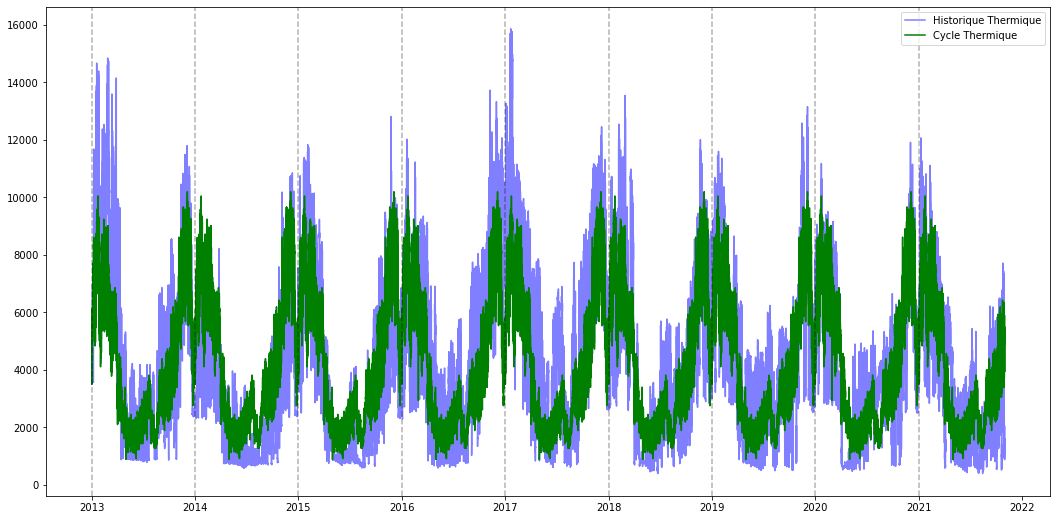

In [17]:
plt.figure(figsize = (18, 9))
plt.plot(thermique['Thermique'], color = 'b', alpha = 0.5, label = 'Historique Thermique')
plt.plot(thermique['Avg_thermique'], color = 'g', label = 'Cycle Thermique')
plt.legend(loc = 'upper right')
for i in range(2013, 2022):
    plt.axvline(dt.datetime(i, 1, 1), color = 'k', alpha = 0.3, linestyle = '--');

In [18]:
thermique = thermique[(thermique.index >= dt.datetime(2020,1,1))&(thermique.index < dt.datetime(2021,11,1))]

## Compilation des résultats

In [19]:
df = pd.concat([df, nucleaire], axis = 1)
df = pd.concat([df, thermique], axis = 1)
df['Balance_p_yc_thermique'] = df['Sol_p_exog'] + df['Eol_p_LinReg'] + df['Hyd_p_exog'] + df['Avg_nucleaire'] + df['Avg_thermique'] - df['Conso_p_exog']
df['Balance_p_no_thermique'] = df['Sol_p_exog'] + df['Eol_p_LinReg'] + df['Hyd_p_exog'] + df['Avg_nucleaire'] - df['Conso_p_exog']

## Balance réelle et balance prédite en 1 étape

Pour comparer les performances, nous incluons la balance réelle observée ainsi que la balance prédite suivant sa propre série temporelle.

In [20]:
balance_pred = pd.read_csv('./results/3h/bilan_balance_3h.csv', sep = ';',
                     usecols = ['Dates', 'Bal_p_LinReg'])
balance_pred['Dates'] = pd.to_datetime(balance_pred['Dates'], yearfirst = True)
balance_pred.set_index('Dates', inplace = True)
balance_pred = balance_pred[(balance_pred.index >= dt.datetime(2020,1,1))&(balance_pred.index < dt.datetime(2021,11,1))]

In [21]:
df = pd.concat([df, balance_pred], axis = 1)

In [22]:
balance_reel = pd.read_csv('./dataset/France_3h.csv',
                     usecols = ['Dates', 'Balance'])
balance_reel['Dates'] = pd.to_datetime(balance_reel['Dates'], yearfirst = True)
balance_reel.set_index('Dates', inplace = True)
balance_reel = balance_reel[(balance_reel.index >= dt.datetime(2020,1,1))&(balance_reel.index < dt.datetime(2021,11,1))]

In [23]:
df = pd.concat([df, balance_reel], axis = 1)
df.head(1)

,Sol_p_exog,Hyd_p_exog,Eol_p_LinReg,Conso_p_exog,Nucléaire,Avg_nucleaire,Thermique,Avg_thermique,Balance_p_yc_thermique,Balance_p_no_thermique,Bal_p_LinReg,Balance
Dates,,,,,,,,,,,,
2020-01-01,255.256338,6023.128,3027.765656,57857.919526,49465.0,51234.503704,5973.5,4270.851852,6953.586022,2682.73417,5896.380612,4203.833333


In [24]:
df.to_csv('bilan_balance_indirecte_3h.csv', sep=';')

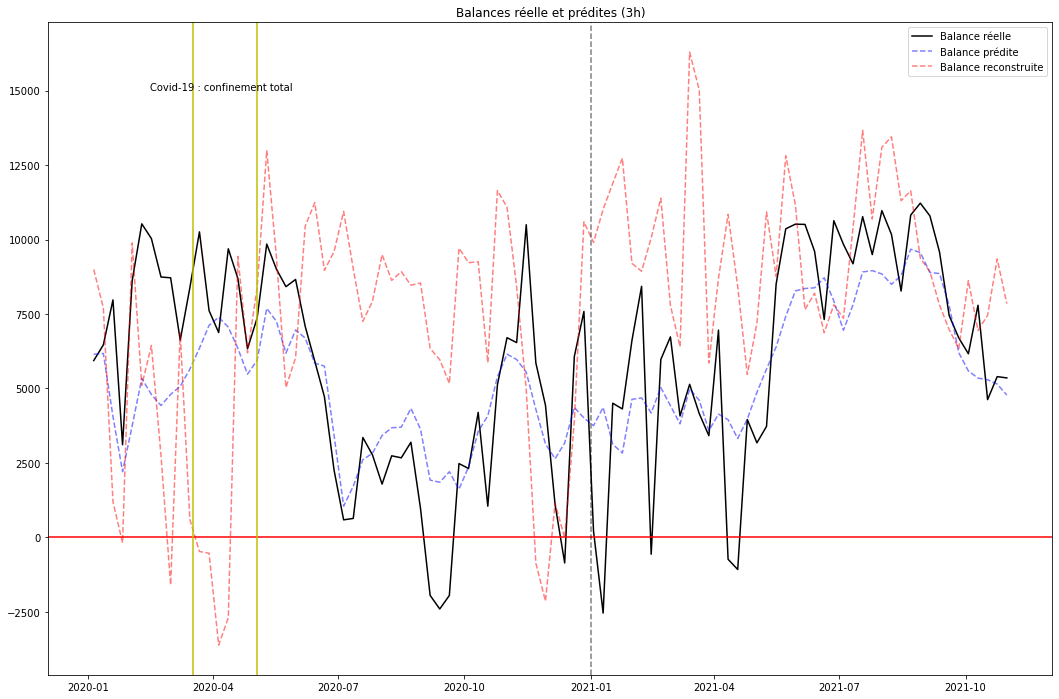

In [25]:
plt.figure(figsize = (18, 12))
plt.plot(df['Balance'].resample('W').mean(), color = 'k', label = 'Balance réelle')
plt.plot(df['Bal_p_LinReg'].resample('W').mean(), color = 'b', alpha = 0.5, linestyle = '--', label = 'Balance prédite')
plt.plot(df['Balance_p_yc_thermique'].resample('W').mean(), color = 'r', alpha = 0.5, linestyle = '--', label = 'Balance reconstruite')
# plt.plot(df['Balance_p_no_thermique'].resample('W').mean(), color = 'g', alpha = 0.5, linestyle = '--', label = 'Balance reconstruite no thermique')
plt.title('Balances réelle et prédites (3h)')
plt.legend(loc = 'upper right')
plt.axhline(0, color = 'r')
plt.axvline(dt.datetime(2021, 1, 1), color = 'k', linestyle = '--', alpha = 0.5)
plt.axvline(dt.datetime(2020, 3, 17), color = 'y')
plt.axvline(dt.datetime(2020, 5, 3), color = 'y')
plt.text(dt.datetime(2020, 2, 15), 15000, 'Covid-19 : confinement total')
;
plt.savefig('./results/3h/result_balances_3h.png')

# Calcul des erreurs

In [26]:
df['Err_bal_pred'] = np.abs(df['Bal_p_LinReg'] - df['Balance'])
df['Err_bal_reconst_th'] = np.abs(df['Balance_p_yc_thermique'] - df['Balance'])
df['Err_bal_reconst_noth'] = np.abs(df['Balance_p_no_thermique'] - df['Balance'])
result = df[['Err_bal_pred', 'Err_bal_reconst_th', 'Err_bal_reconst_noth']].describe()
result

,Err_bal_pred,Err_bal_reconst_th,Err_bal_reconst_noth
count,5360.000000,5360.000000,5360.000000
mean,2828.162040,5919.604828,6353.775886
std,2136.098942,4588.911842,5294.538758
min,0.480668,0.745680,2.694852
25%,1141.513984,2366.351677,2390.065943
50%,2377.499053,4893.105116,4993.388685
75%,4020.421812,8309.352698,8688.472032
max,15313.798458,29263.954939,30019.641483


In [27]:
result.to_csv('./results/3h/result_balances_3h_erreur.csv', sep = ';')